In [1]:
%pip install xgboost imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import scipy.stats.distributions as dists
import pandas as pd
import yaml

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
SUBSET = 0
EPOCH = 32
TEST_SIZE = 0.25
USE_FOURIER_COMPONENTS = False
OVER_SAMPLING = True

with open("config.yml", 'r') as f:
    config = yaml.safe_load(f)

if config is not None:
    subset_id = int(config["variables"]["dataset"]["subset"])
    PATH_TO_SUBSET = Path(config["paths"]["local"][f"subset_{SUBSET}_directory"])

    if f"subset_{SUBSET}_continuous_testing_directory" in config["paths"]["local"]:
        PATH_TO_SUBSET_CONT_TESTING = Path(
            config["paths"]["local"][f"subset_{SUBSET}_continuous_testing_directory"])
    else:
        PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = config["variables"]["models"]["net_type"]
    IDENTIFIER = config["variables"]["models"]["net_identifier"]
else:
    subset_id = 1
    PATH_TO_SUBSET = Path(__file__).parent.joinpath("data", "subset-1")
    PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = "UResIncNet"
    IDENTIFIER = "ks3-depth8-strided-0"

PATH_TO_META_MODEL = PATH_TO_SUBSET_CONT_TESTING.joinpath("meta-model", f"trainedOn-subset-{subset_id}",
                                                            str(NET_TYPE), str(IDENTIFIER), f"epoch-{EPOCH}")

print(NET_TYPE)
print(IDENTIFIER)
print(f"Epoch: {EPOCH}")

UResIncNet
ks3-depth8-layers1-strided-adam-lr0.01-0
Epoch: 32


(1756, 56)
Dataframe contains NaN values.
height: 1
weight: 2
bmi: 2
Replacing NaNs with median


<Figure size 3000x3000 with 0 Axes>

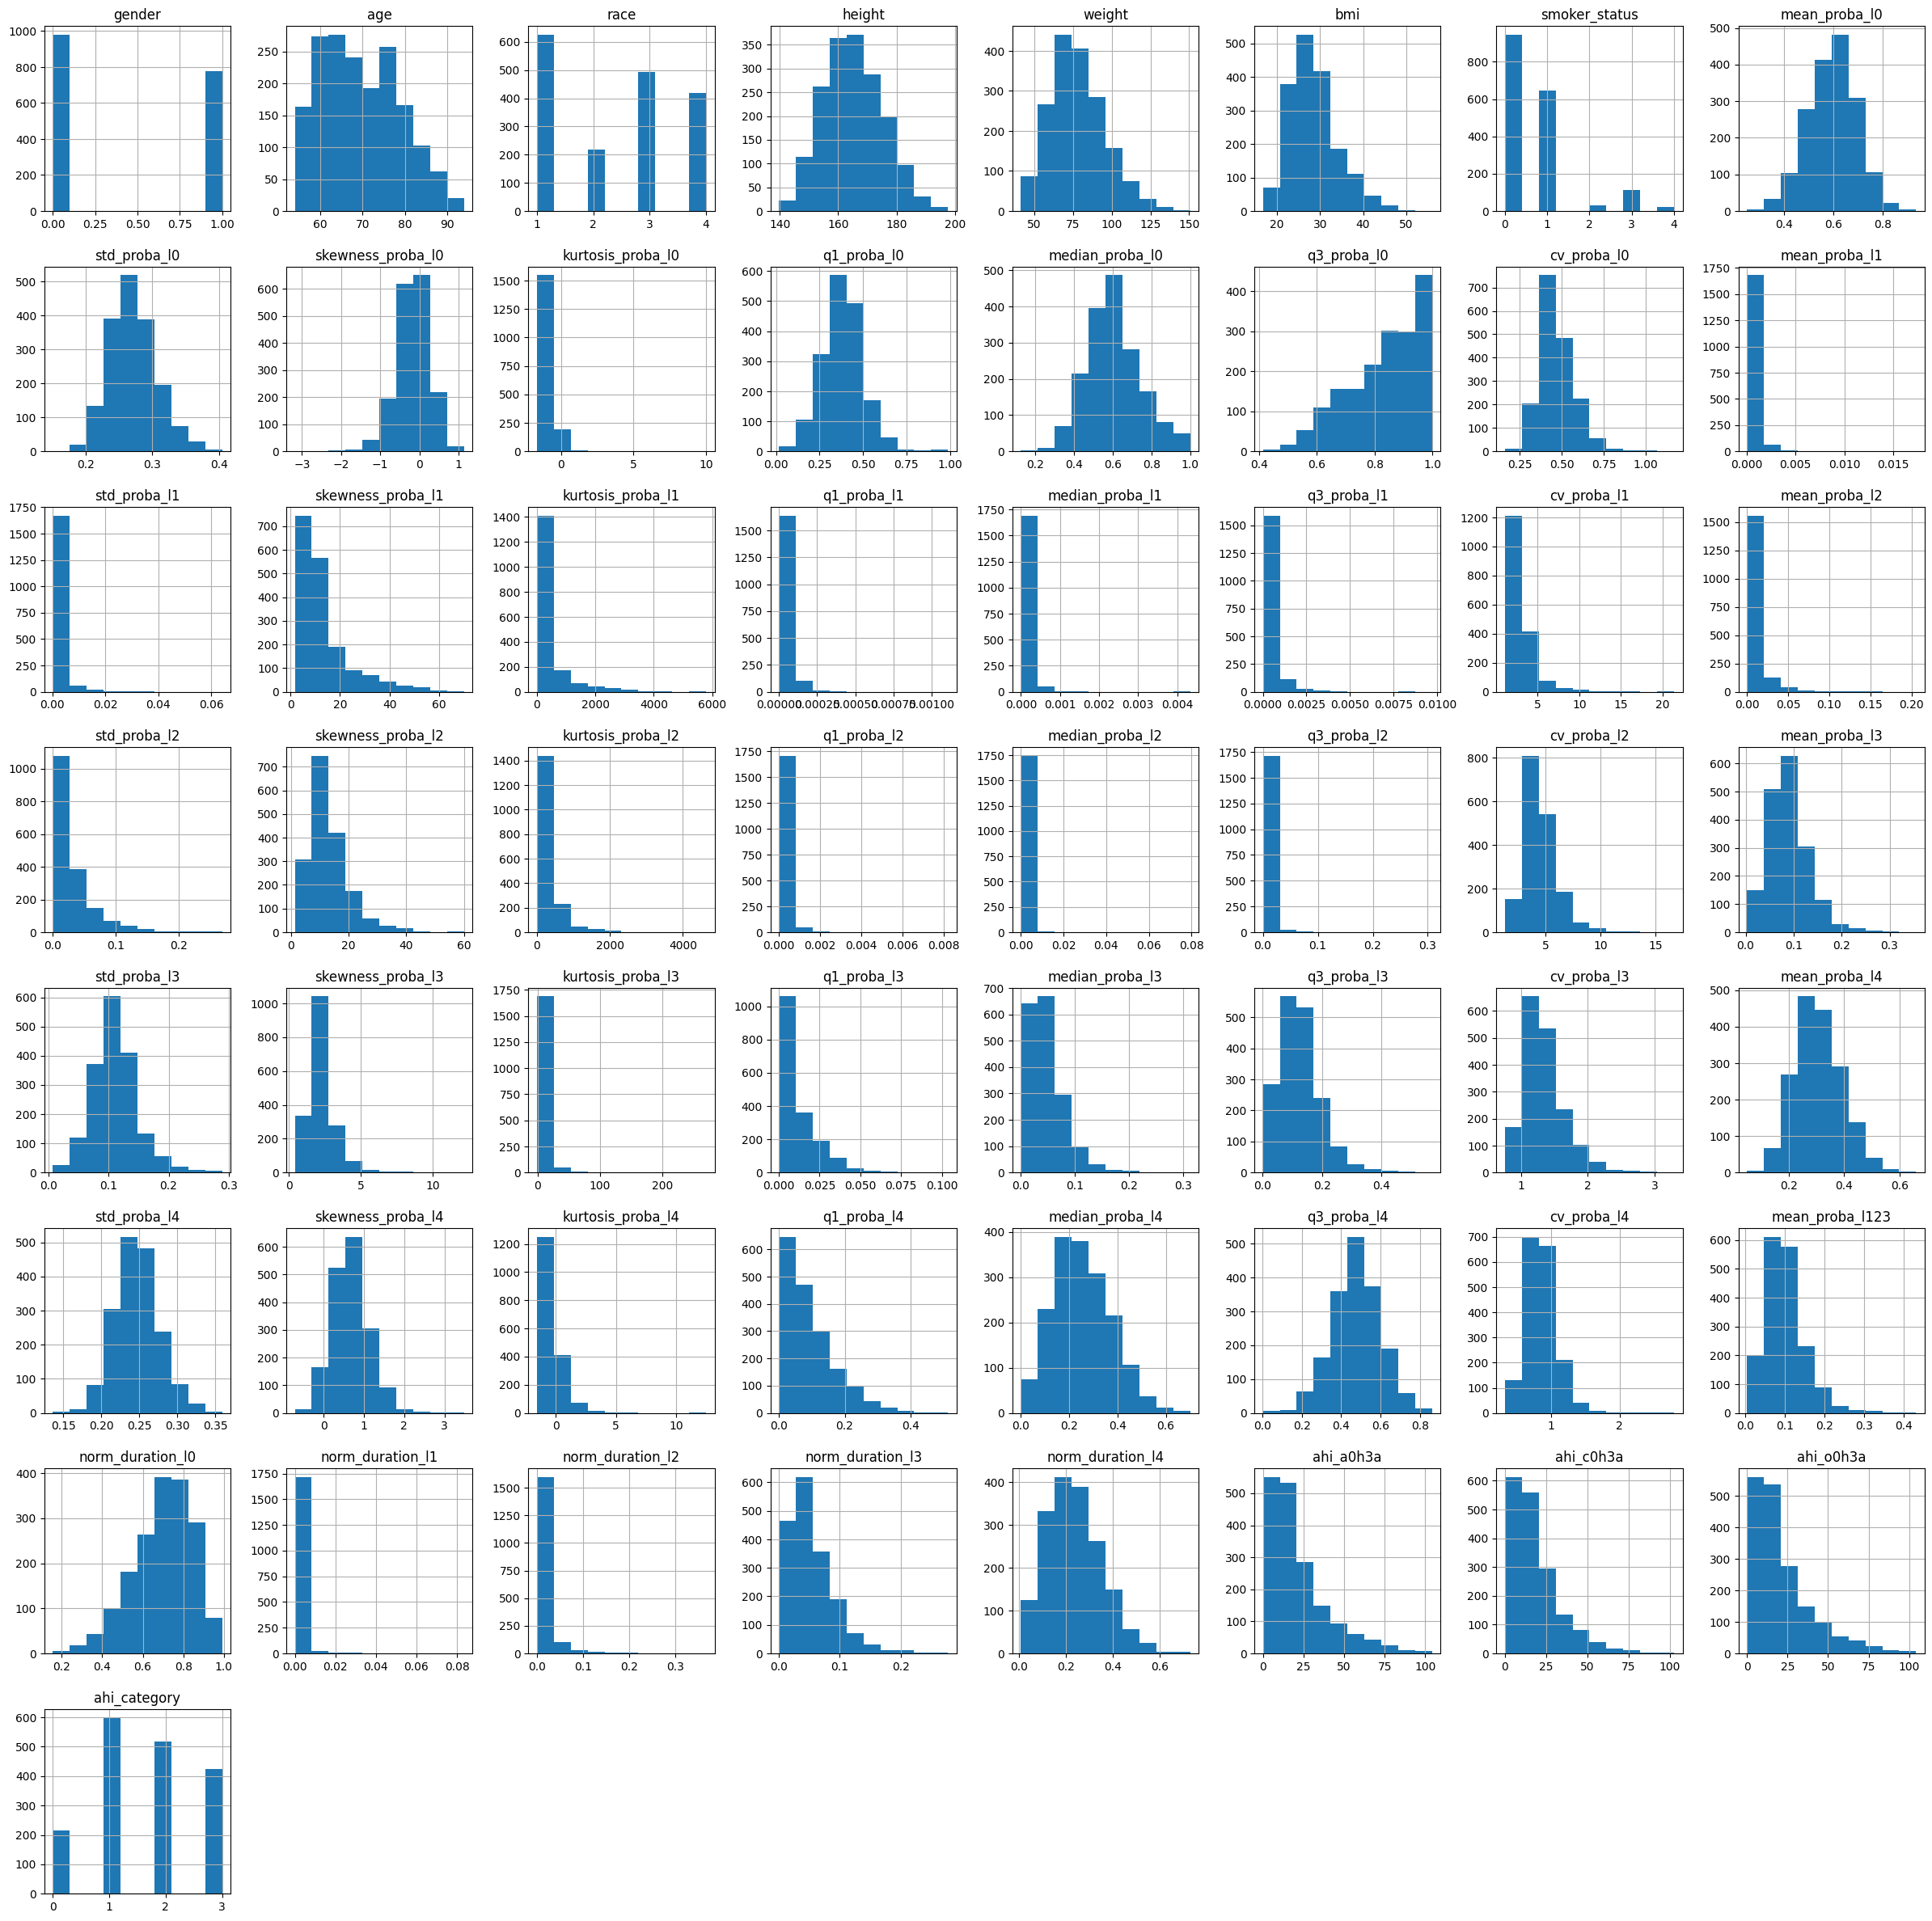

In [4]:
meta_df = pd.read_csv(PATH_TO_META_MODEL.joinpath("meta_df.csv"), index_col=0)
print(meta_df.shape)

if meta_df.isnull().values.any():
    print("Dataframe contains NaN values.")

    for col in meta_df.columns:
        if meta_df[col].isnull().any():
            print(f"{col}: {meta_df[col].isnull().sum()}")

    print("Replacing NaNs with median")
    meta_df.fillna(meta_df.median(axis=0), inplace=True)
    assert not meta_df.isnull().values.any()        
    

meta_df["mean_proba_l123"] = meta_df["mean_proba_l1"] + meta_df["mean_proba_l2"]+ meta_df["mean_proba_l3"]

metadata_columns = ["gender", "age", "race", "height", "weight", "bmi", "smoker_status"]
out_columns = ["norm_duration_l0", "norm_duration_l1", "norm_duration_l2", "norm_duration_l3", "norm_duration_l4",
             "ahi_a0h3a", "ahi_c0h3a", "ahi_o0h3a", "ahi_category"]
in_columns = [c for c in meta_df.columns if c not in out_columns]

fourier_columns = [c for c in in_columns if "_f" in c and 'l' in c]
stat_columns = [c for c in in_columns if c not in fourier_columns]

if not USE_FOURIER_COMPONENTS and len(fourier_columns) > 0:
    meta_df.drop(fourier_columns, axis=1, inplace=True)
    in_columns = [c for c in meta_df.columns if c not in out_columns]

fig = plt.figure(figsize=(30,30))
meta_df[[*stat_columns, *out_columns]].hist(figsize=(30,30))
plt.show()


Top 8 features with largest absolute (positive or negative) correlation with ahi_a0h3a: ['cv_proba_l0' 'std_proba_l4' 'q3_proba_l4' 'q1_proba_l0' 'mean_proba_l4'
 'std_proba_l0' 'mean_proba_l0' 'median_proba_l4']


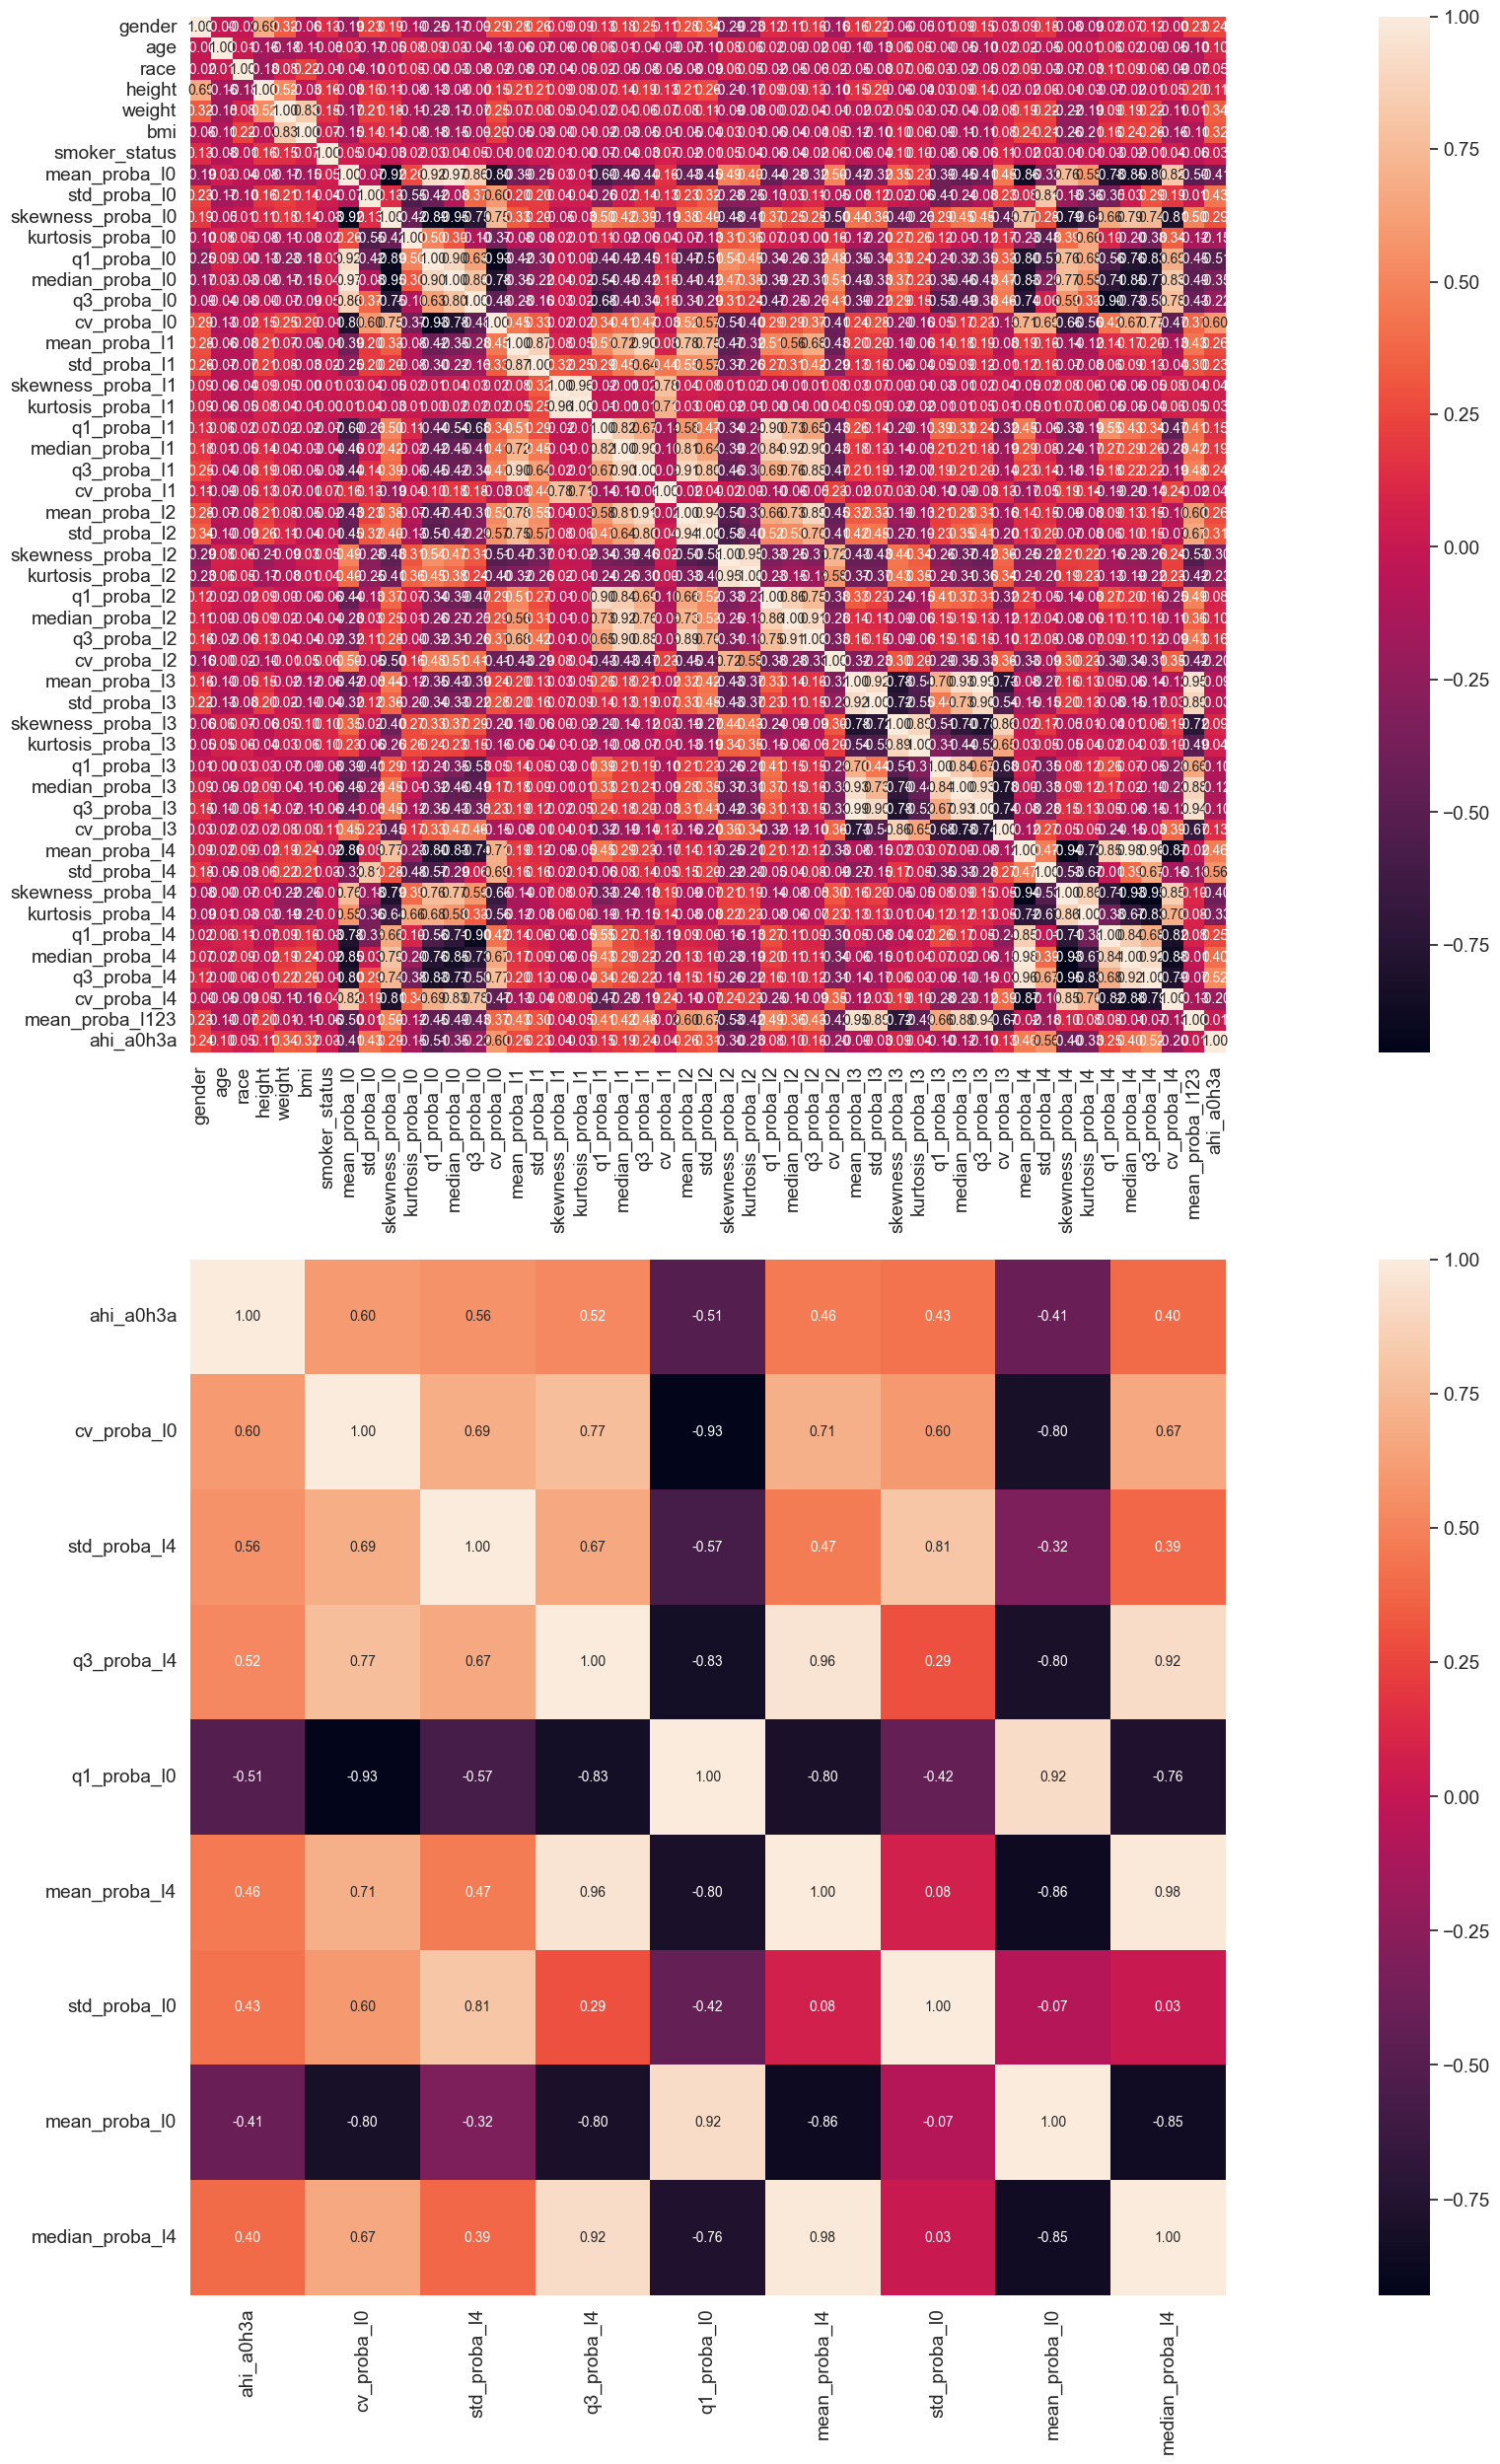

In [5]:
def plot_correl_matrix(df, target, k=8):
    # k = features to select
    corrmat = df.corr()
    sns.set(font_scale=1.25)
    if k>0 and k<len(df.columns):
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(40,30))
        
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values, ax=ax[0])

        largest_abs_corr_cols = corrmat.abs().nlargest(k+1, target)[target].index
        cm = np.corrcoef(df[largest_abs_corr_cols].values.T)

        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=largest_abs_corr_cols.values, xticklabels=largest_abs_corr_cols.values, ax=ax[1]) 

        largest_abs_corr_cols = np.delete(largest_abs_corr_cols.values, 0) # remove target
        print(f"Top {k} features with largest absolute (positive or negative) correlation with {target}: {largest_abs_corr_cols}")
    else:
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values)

def classification_performance(y_true, y_hat, test=True, plot_confusion=True, target_labels=None, normalize=None):
    """
    :param normalize: {'true', 'pred', 'all'} or None
    """ 
    train_test =  "test" if test else "train"
    accuracy = accuracy_score(y_true, y_hat)

    if plot_confusion:
        cm = confusion_matrix(y_true, y_hat, normalize=normalize)
        #print(cm)
        if not target_labels:
            df_cm = pd.DataFrame(cm)
        else:    
            df_cm = pd.DataFrame(cm, index = target_labels,
                            columns = target_labels)
        plt.figure(figsize = (7,5))
        plt.title(f"Accuracy ({train_test})  %0.1f%% " % ( accuracy * 100))
        sns.set_theme(font_scale=1) # for label size
        if normalize:
            sns.heatmap(df_cm, annot=True, fmt=".2f",)

        else:
            sns.heatmap(df_cm, annot=True, fmt="d")   
        plt.xlabel("Predicted")
        plt.ylabel("True")    
        plt.show()
    else:
        print(f"Accuracy ({train_test})  %0.1f%% " % ( accuracy * 100))

    return accuracy

target="ahi_a0h3a"
plot_correl_matrix(meta_df[[*in_columns, target]], target=target)

## Train test split

In [6]:
meta_train_df, meta_test_df = train_test_split(meta_df, test_size=TEST_SIZE, random_state=33,
                                                shuffle=True, stratify=meta_df["ahi_category"])

X_train_df: pd.DataFrame = meta_train_df[in_columns]
Y_train_df: pd.DataFrame = meta_train_df[out_columns]

X_test_df: pd.DataFrame = meta_test_df[in_columns]
Y_test_df: pd.DataFrame = meta_test_df[out_columns]

## Oversampling:

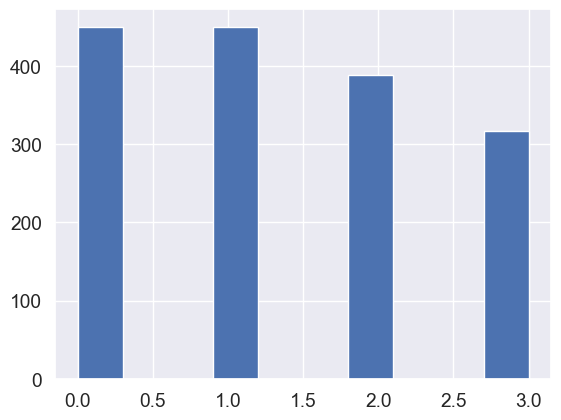

In [7]:
if OVER_SAMPLING:
    ros = RandomOverSampler(sampling_strategy="minority", random_state=33)

    X_train_df, _ = ros.fit_resample(meta_train_df[in_columns], meta_train_df["ahi_category"])
    inds = ros.sample_indices_
    extra_inds = inds[len(meta_train_df):]
    Y_train_df = pd.concat([meta_train_df[out_columns], meta_train_df[out_columns].iloc[extra_inds, :]], axis=0, ignore_index=True)

    Y_train_df["ahi_category"].hist()

else:
    X_train_df: pd.DataFrame = meta_train_df[in_columns]
    Y_train_df: pd.DataFrame = meta_train_df[out_columns]   

In [8]:
X_test_df: pd.DataFrame = meta_test_df[in_columns]
Y_test_df: pd.DataFrame = meta_test_df[out_columns]

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

Y_train_clas = Y_train_df["ahi_category"].to_numpy().ravel()
Y_test_clas = Y_test_df["ahi_category"].to_numpy().ravel()

Y_train_reg = Y_train_df.drop("ahi_category", axis=1, inplace=False).to_numpy()
Y_test_reg = Y_test_df.drop("ahi_category", axis=1, inplace=False).to_numpy()

## Standardization:

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Classification

### Baseline

g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


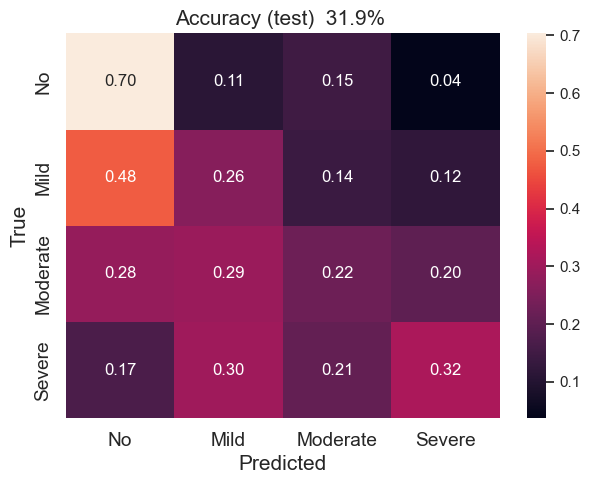

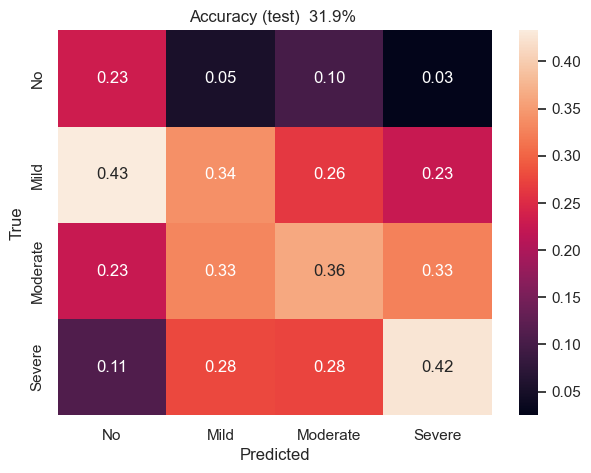

0.31890660592255127

In [10]:
baseline = LogisticRegression(random_state=33)
baseline.fit(X_train_df[metadata_columns].to_numpy(), Y_train_clas)
classification_performance(Y_test_clas, baseline.predict(X_test_df[metadata_columns].to_numpy()), test=True, plot_confusion=True, 
                           target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
classification_performance(Y_test_clas, baseline.predict(X_test_df[metadata_columns].to_numpy()), test=True, plot_confusion=True, 
                           target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### Model Selection

In [11]:
models = [LogisticRegression(random_state=33, solver="newton-cg"), RandomForestClassifier(random_state=33), SVC(random_state=33), XGBClassifier(seed=33)]

for model in models:
    scores = cross_validate(estimator=model, X=X_train, y=Y_train_clas, scoring="accuracy", cv=5)
    acc = np.mean(scores["test_score"])
    print(f"{model} -> {100*acc:2.2f}%")

LogisticRegression(random_state=33, solver='newton-cg') -> 50.93%
RandomForestClassifier(random_state=33) -> 64.01%
SVC(random_state=33) -> 53.67%
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) -> 63.76%


#### Logistic

In [12]:
model = LogisticRegression(random_state=33)

parameters = {'multi_class':['auto'],
              'penalty': ['l1', 'l2'],
              'C': np.linspace(0.2,1.0, num=10, endpoint=True),
              'solver': ['liblinear', 'newton-cg', 'saga']}
clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", refit=True)
clf.fit(X_train, Y_train_clas)

print(clf.best_score_)
best_logistic = clf.best_estimator_
best_logistic_params = clf.best_params_
best_logistic_params

g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: T

0.5112188231651864


g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 0.5555555555555556,
 'multi_class': 'auto',
 'penalty': 'l2',
 'solver': 'saga'}

Recall


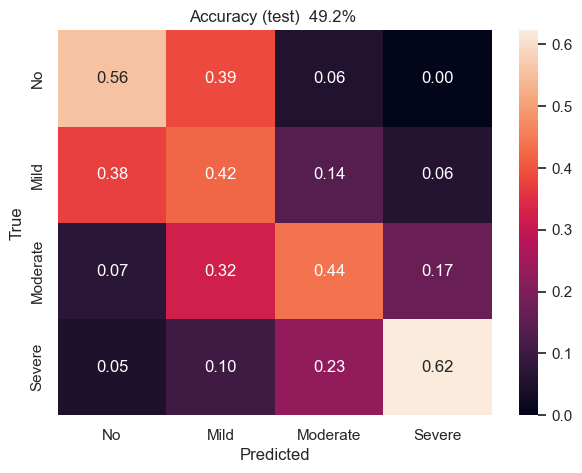

Precision


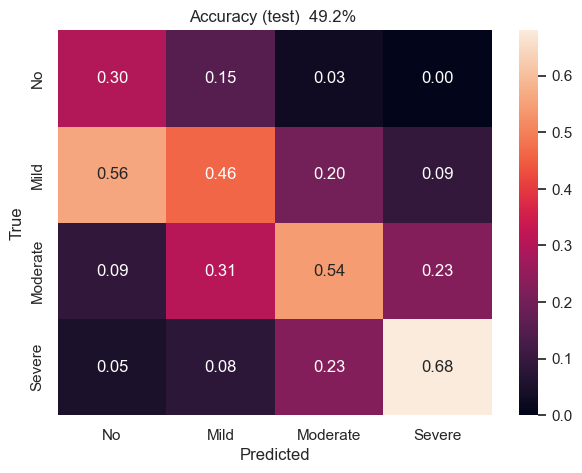

0.4920273348519362

In [13]:
print("Recall")
classification_performance(Y_test_clas, best_logistic.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
print("Precision")
classification_performance(Y_test_clas, best_logistic.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

Test accuracy: 49.20%


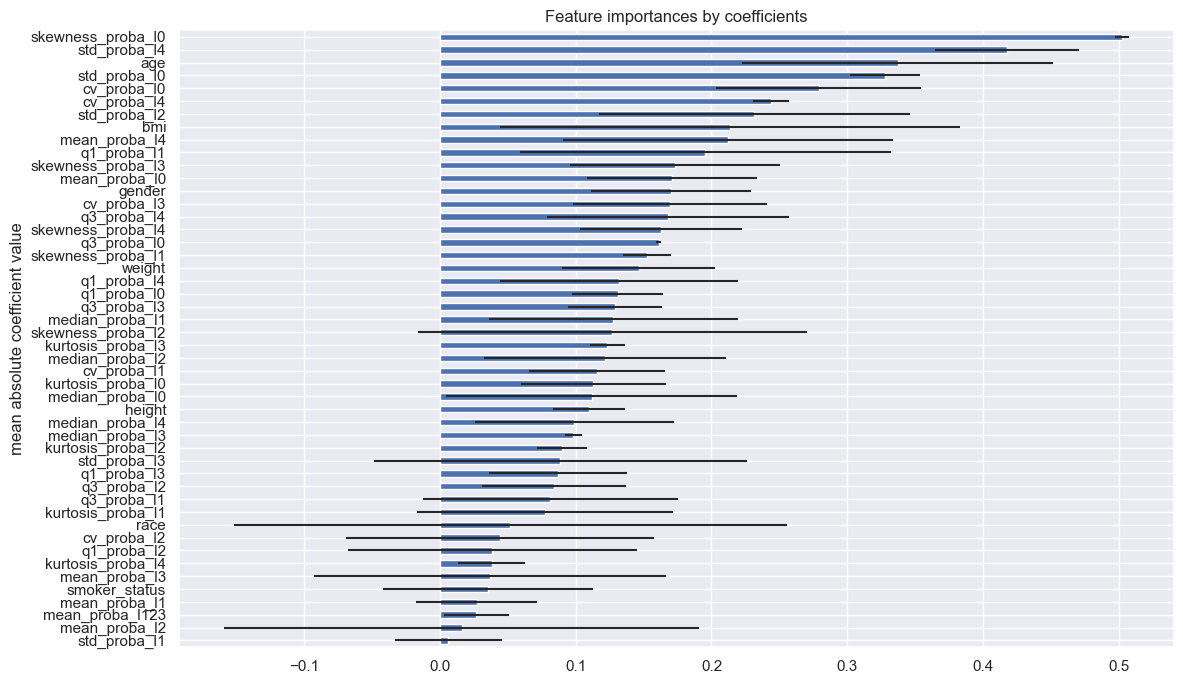

In [14]:
print(f"Test accuracy: {100*accuracy_score(Y_test_clas, best_logistic.predict(X_test)):.2f}%")


importances = np.mean(np.abs(best_logistic.coef_), axis=0)
std = np.std(np.abs(best_logistic.coef_), axis=0)
importances_s = pd.Series(importances, index=in_columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,7))
importances_s.plot.barh(xerr=std, ax=ax)
ax.set_title(f"Feature importances by coefficients")
ax.set_ylabel("mean absolute coefficient value")
fig.tight_layout()

### SVC

In [15]:
if True:
    model = SVC(random_state=33)

    parameters = {'degree': [2, 3, 4],
                'gamma': ["scale", "auto"],
                'C': np.linspace(0.1,1.0, num=20, endpoint=True),
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", refit=True)
    clf.fit(X_train, Y_train_clas)

    print(clf.best_score_)
    best_svm = clf.best_estimator_
    best_svm_params = clf.best_params_
    best_svm_params
else:
    parameters = {'degree': 2,
                'gamma': "scale",
                'C': 0.1,
                'kernel': 'rbf'}
    best_svm = SVC(random_state=33, **parameters)
    best_svm.fit(X_train, Y_train_clas)

    scores = cross_validate(estimator=best_svm, X=X_train, y=Y_train_clas, scoring='accuracy', cv=5)["test_score"]
    print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

0.5367446450339584


Recall


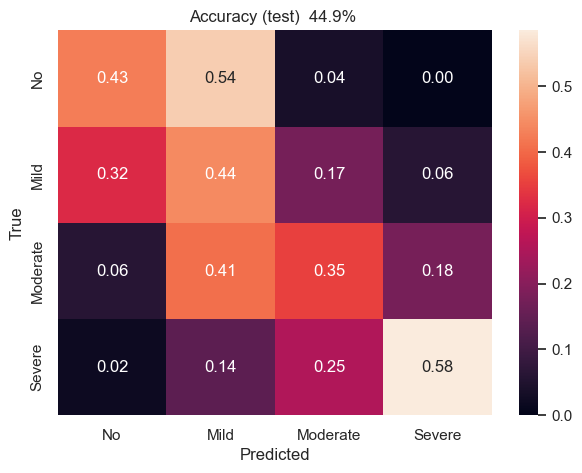

Precision


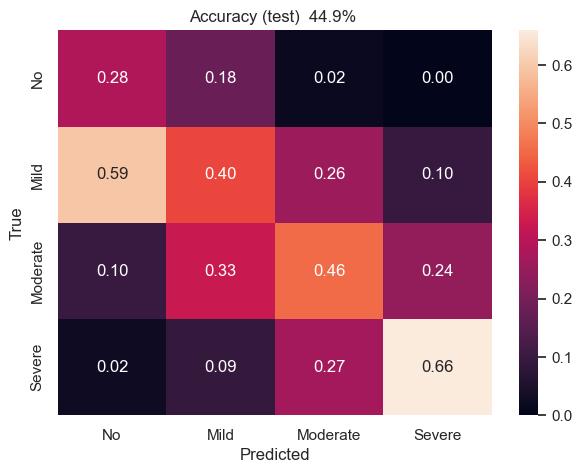

0.44874715261959

In [16]:
print("Recall")
classification_performance(Y_test_clas, best_svm.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
print("Precision")
classification_performance(Y_test_clas, best_svm.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### Random Forest

In [17]:
if True:
    rf_clas = RandomForestClassifier(random_state=33)

    parameters = {'n_estimators':[100], 
                'criterion': ['gini'],
                'max_depth':[5, 7, 9],
                'min_samples_split': [2, 3, 4],
                'min_samples_leaf': [1, 2, 3, 4],
                'max_features': ("sqrt", 'log2')}
    clf = GridSearchCV(rf_clas, parameters, cv=5, scoring="accuracy", refit=True)
    clf.fit(X_train, Y_train_clas)

    print(clf.best_score_)
    best_rfc = clf.best_estimator_
    best_params = clf.best_params_
    print(best_params)
else:
    parameters = {'n_estimators': 200, 
                'criterion': 'entropy',
                'max_depth': 9,
                'min_samples_split': 3,
                'min_samples_leaf': 1,
                'max_features': "sqrt"}
    best_rfc = RandomForestClassifier(random_state=33, **parameters)
    best_rfc.fit(X_train, Y_train_clas)
    scores = cross_validate(estimator=best_rfc, X=X_train, y=Y_train_clas, scoring='accuracy', cv=5)["test_score"]
    print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")


0.6388576072444417
{'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


Recall


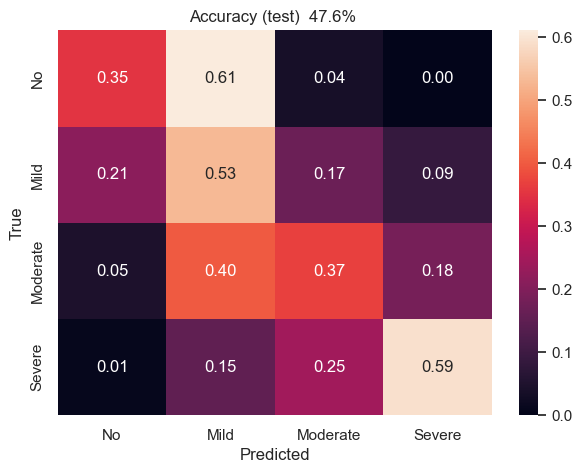

Precision


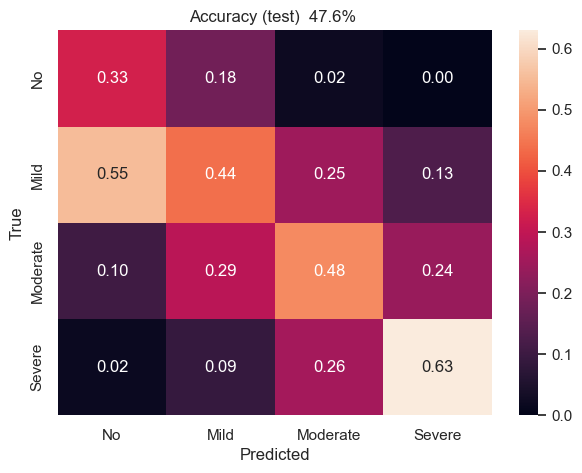

0.4760820045558087

In [18]:
print("Recall")
classification_performance(Y_test_clas, best_rfc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
print("Precision")
classification_performance(Y_test_clas, best_rfc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

Test accuracy: 47.61%


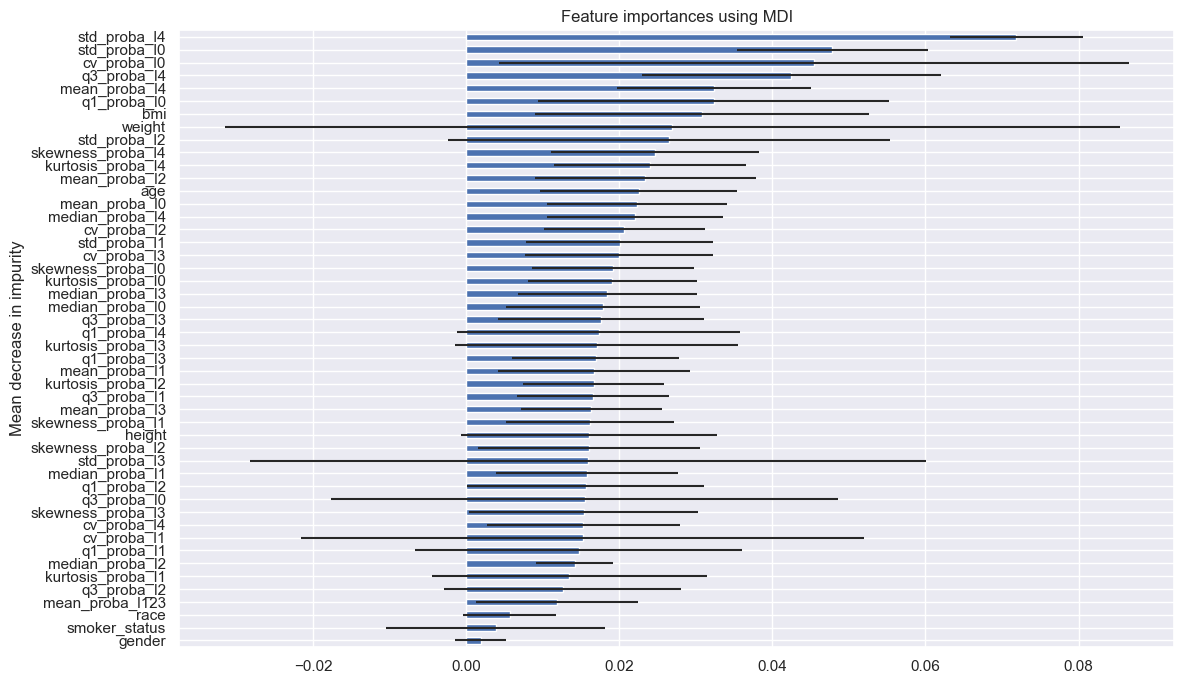

In [19]:
print(f"Test accuracy: {100*accuracy_score(Y_test_clas, best_rfc.predict(X_test)):.2f}%")

importances = best_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rfc.estimators_], axis=0)
forest_importances = pd.Series(best_rfc.feature_importances_, index=in_columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(12,7))
forest_importances.plot.barh(xerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### XGBoost

In [20]:
if True:
    xgbc = XGBClassifier(seed=33)

    parameters = {'eta': [0.1,0.2,0.3], 
                'gamma': [0, 0.05, 0.1],
                'max_depth':[4, 5, 6],
                'subsample': [0.7, 0.8, 0.9],
                'colsample_bytree': [0.7, 0.8, 0.9],
                'colsample_bynode': [0.7, 0.8, 0.9],
                'lambda': np.arange(0.7,1.0,0.1),
                'alpha': np.arange(0.7, 1.0,0.1)}

    clf = RandomizedSearchCV(xgbc, parameters, cv=5, n_iter=100, scoring="accuracy", refit=True)
    clf.fit(X_train, Y_train_clas)

    print(clf.best_score_)
    xgbc = clf.best_estimator_
    best_params = clf.best_params_
    print(best_params)
else:
    parameters = {'subsample': 0.9,
                'max_depth': 6,
                'lambda': 0.8,
                'gamma': 0.1,
                'eta': 0.2,
                'colsample_bytree': 0.7,
                'colsample_bynode': 0.9,
                'alpha': 0.9}    
    xgbc = XGBClassifier(random_state=33, **parameters)
    xgbc.fit(X_train, Y_train_clas)
    scores = cross_validate(estimator=xgbc, X=X_train, y=Y_train_clas, scoring='accuracy', cv=5)["test_score"]
    print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

0.6563088949517231
{'subsample': 0.9, 'max_depth': 5, 'lambda': 0.9999999999999999, 'gamma': 0, 'eta': 0.2, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'alpha': 0.7999999999999999}


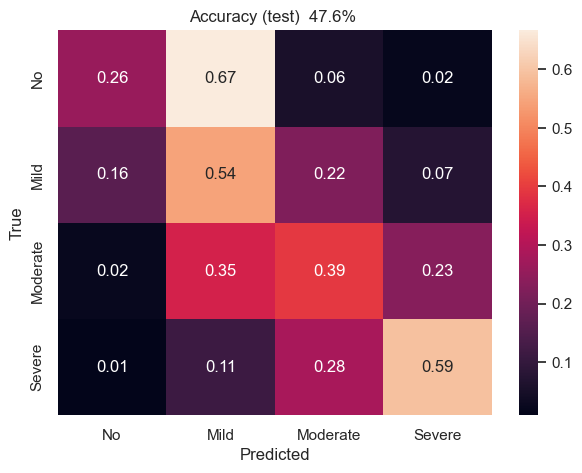

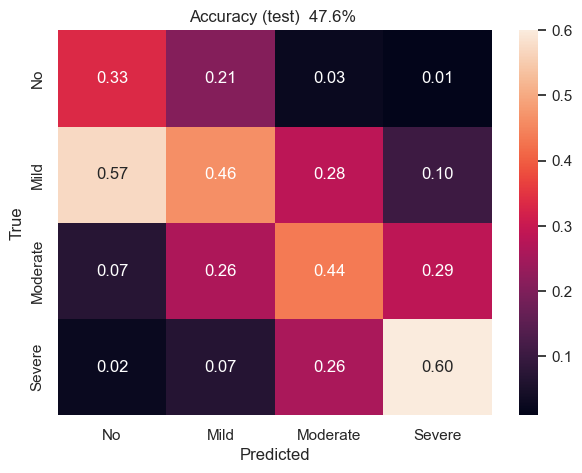

0.4760820045558087

In [21]:
classification_performance(Y_test_clas, xgbc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
classification_performance(Y_test_clas, xgbc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

## Regression

In [22]:
def ahi_to_category(ahi: float) -> int:
    if ahi < 5.0:
        # No
        return 0
    elif ahi < 15.0:
        # Mild
        return 1
    elif ahi < 30.0:
        # Moderate
        return 2
    else:
        # Severe
        return 3

ahi_to_category_vf = np.vectorize(ahi_to_category)    

In [23]:
Y_train_reg.shape

(1606, 8)

In [24]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train_reg)
Y_train_reg_scaled = Y_scaler.transform(Y_train_reg)

models = {"lr": LinearRegression(), "ridge": Ridge(), "svr": SVR(), "rf": RandomForestRegressor(random_state=33), "xgb": XGBRegressor(seed=33)}

cv_splitter = [(train_indices, validation_indices) for (train_indices, validation_indices) in StratifiedKFold(n_splits=5).split(X_train, y=Y_train_clas)]

for name, model in models.items():
    print(f"Model: {name}")
    for i, var in enumerate(out_columns[0:-1]):
        scores = cross_validate(estimator=model, X=X_train, y=Y_train_reg_scaled[:,i], scoring='r2', cv=cv_splitter)["test_score"]
        print(f"Target: {var} -> Mean score: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

Model: lr
Target: norm_duration_l0 -> Mean score: 0.5899, Std: 0.0384, CV: 6.51%
Target: norm_duration_l1 -> Mean score: -0.3174, Std: 0.5712, CV: 179.95%
Target: norm_duration_l2 -> Mean score: 0.1487, Std: 0.2338, CV: 157.17%
Target: norm_duration_l3 -> Mean score: 0.1008, Std: 0.0423, CV: 41.93%
Target: norm_duration_l4 -> Mean score: 0.5759, Std: 0.0214, CV: 3.72%
Target: ahi_a0h3a -> Mean score: 0.5472, Std: 0.0492, CV: 8.99%
Target: ahi_c0h3a -> Mean score: 0.4774, Std: 0.0468, CV: 9.81%
Target: ahi_o0h3a -> Mean score: 0.5492, Std: 0.0440, CV: 8.01%
Model: ridge
Target: norm_duration_l0 -> Mean score: 0.5952, Std: 0.0370, CV: 6.21%
Target: norm_duration_l1 -> Mean score: -0.2600, Std: 0.5069, CV: 194.92%
Target: norm_duration_l2 -> Mean score: 0.1606, Std: 0.2184, CV: 135.99%
Target: norm_duration_l3 -> Mean score: 0.1076, Std: 0.0400, CV: 37.19%
Target: norm_duration_l4 -> Mean score: 0.5817, Std: 0.0186, CV: 3.20%
Target: ahi_a0h3a -> Mean score: 0.5547, Std: 0.0430, CV: 7.74%

### Ridge

In [25]:
model = Ridge(random_state=33)

parameters = {'alpha': np.linspace(0.0,20.0, num=100, endpoint=True)}
clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
clf.fit(X_train, Y_train_reg[:,5])

print(clf.best_score_)
best_ridge = clf.best_estimator_
best_ridge_params = clf.best_params_
best_ridge_params

g:\filip\Documents\Data Science Projects\Thesis\apnea-ppg\venv\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.30746e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


0.5628380094841553


{'alpha': 8.080808080808081}

Test R^2: 0.56
MAE: 8.18
CV(RMSE): 54.14%
---------------------------------------------------------------


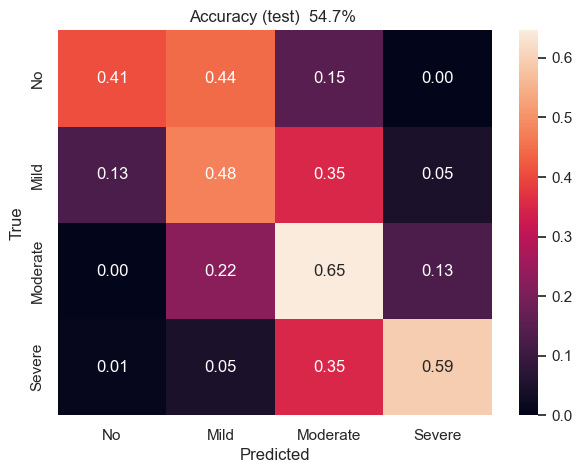

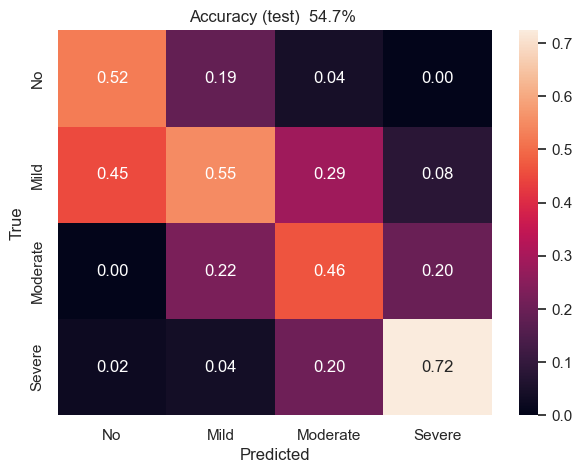

0.5466970387243736

In [26]:
mdl = best_ridge

y_hat = mdl.predict(X_test)
y_true = Y_test_reg[:,5]

y_hat_clas = ahi_to_category_vf(y_hat)
y_true_clas = Y_test_clas


r2 = r2_score(y_true=y_true, y_pred=y_hat)
mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
y_mean = np.mean(y_true)
accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)

print(f"Test R^2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
print("---------------------------------------------------------------")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### SVR

In [27]:
Y_scaler_ahi = StandardScaler()
Y_scaler_ahi.fit(Y_train_reg[:,5].reshape(-1,1))
Y_train_ahi_scaled = Y_scaler_ahi.transform(Y_train_reg[:,5].reshape(-1,1)).ravel()
if True:
    model = SVR()

    parameters = {'degree': [2, 3, 4],
                'gamma': ["scale", "auto"],
                'C': np.linspace(0.1,1.0, num=10, endpoint=True),
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
    clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
    clf.fit(X_train, Y_train_ahi_scaled)

    print(clf.best_score_)
    best_svr= clf.best_estimator_
    best_svr_params = clf.best_params_
    print(best_svr_params)
else:
    parameters = {'C': 1.0, 
                  'degree': 2, 
                  'gamma': 'auto', 
                  'kernel': 'rbf'}
    best_svr = SVR(**parameters)
    best_svr.fit(X_train, Y_train_ahi_scaled)
    scores = cross_validate(estimator=best_svr, X=X_train, y=Y_train_ahi_scaled, scoring='r2', cv=5)["test_score"]

0.5913133397972039
{'C': 1.0, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}


Test R^2: 0.54
MAE: 8.11
CV(RMSE): 55.23%
---------------------------------------------------------------


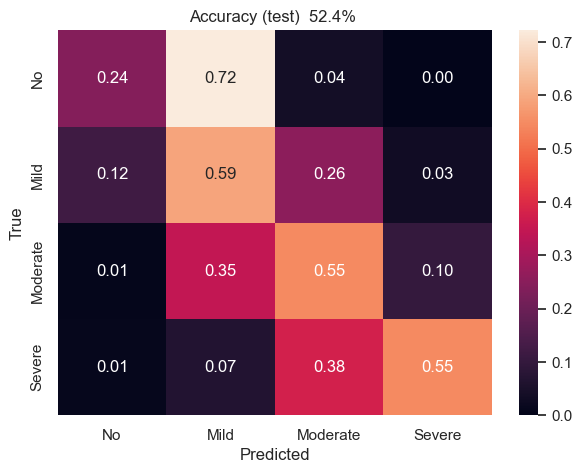

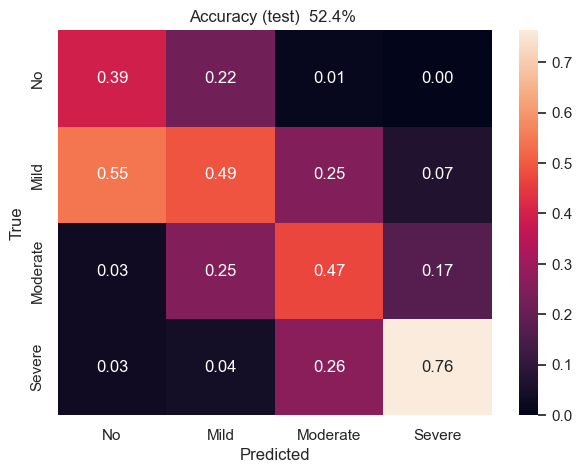

0.5239179954441914

In [28]:
y_hat = Y_scaler_ahi.inverse_transform(best_svr.predict(X_test).reshape(-1,1)).ravel()
y_true = Y_test_reg[:,5]

y_hat_clas = ahi_to_category_vf(y_hat)
y_true_clas = Y_test_clas

r2 = r2_score(y_true=y_true, y_pred=y_hat)
mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
y_mean = np.mean(y_true)
accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)

print(f"Test R^2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
print("---------------------------------------------------------------")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### Random Forest Regression

In [29]:
if True:
    model = RandomForestRegressor(random_state=33)

    parameters = {'n_estimators':[100], 
                'max_depth':[10, 15, 20, None],
                'min_samples_split': [2, 3, 4],
                'min_samples_leaf': [1, 2, 3],
                'max_features': ("sqrt", 'log2')}

    clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
    clf.fit(X_train, Y_train_reg[:,5])

    print(clf.best_score_)
    best_rfr = clf.best_estimator_
    best_rfr_params = clf.best_params_
    best_rfr_params
else:
    parameters = {'max_depth': None,
                'max_features': 'sqrt',
                'min_samples_leaf': 1,
                'min_samples_split': 4,
                'n_estimators': 100} 
    best_rfr = RandomForestRegressor(random_state=33, **parameters)
    best_rfr.fit(X_train, Y_train_reg[:,5])
    scores = cross_validate(estimator=best_rfr, X=X_train, y=Y_train_reg[:,5], scoring='r2', cv=5)["test_score"]
    print(f"Mean cv r2: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

0.618266804415042


Test R^2: 0.50
MAE: 8.73
CV(RMSE): 57.95%
---------------------------------------------------------------


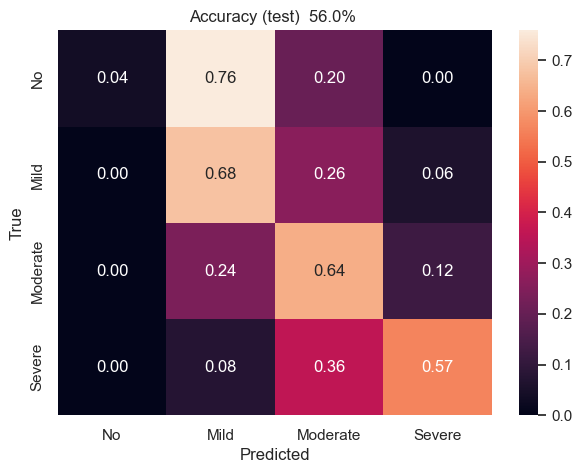

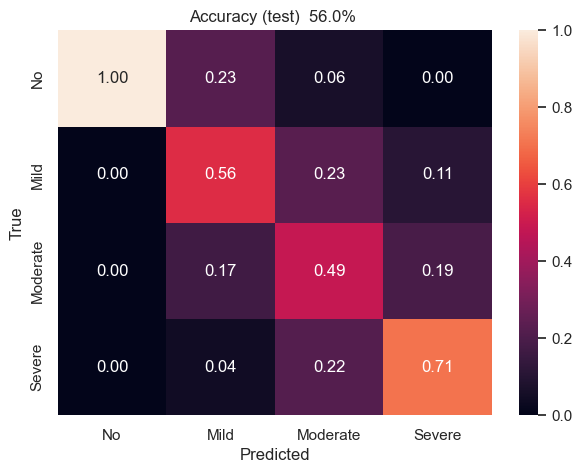

0.5603644646924829

In [30]:
mdl = best_rfr

y_hat = mdl.predict(X_test)
y_true = Y_test_reg[:,5]

y_hat_clas = ahi_to_category_vf(y_hat)
y_true_clas = Y_test_clas


r2 = r2_score(y_true=y_true, y_pred=y_hat)
mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
y_mean = np.mean(y_true)
accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)

print(f"Test R^2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
print("---------------------------------------------------------------")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### XGBoost

In [31]:
if True:
    model = XGBRegressor(seed=33)

    parameters = {'eta': [0.1,0.2,0.3], 
                'gamma': [0, 0.05, 0.1],
                'max_depth':[4, 5, 6],
                'subsample': [0.7, 0.8, 0.9],
                'colsample_bytree': [0.7, 0.8, 0.9],
                'colsample_bynode': [0.7, 0.8, 0.9],
                'lambda': np.arange(0.7,1.0,0.1),
                'alpha': np.arange(0.7, 1.0,0.1)}

    clf = RandomizedSearchCV(model, parameters, n_iter=1000, cv=cv_splitter, scoring="r2", refit=True, random_state=33)
    clf.fit(X_train, Y_train_reg[:,5])

    print(clf.best_score_)
    best_xgbr = clf.best_estimator_
    best_xgbr_params = clf.best_params_
    best_xgbr_params
else:
    parameters = {'max_depth': None,
                'max_features': 'sqrt',
                'min_samples_leaf': 1,
                'min_samples_split': 4,
                'n_estimators': 100} 
    best_xgbr = XGBRegressor(random_state=33, **parameters)
    best_xgbr.fit(X_train, Y_train_reg[:,5])
    scores = cross_validate(estimator=best_xgbr, X=X_train, y=Y_train_reg[:,5], scoring='r2', cv=5)["test_score"]
    print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")      

0.6388903192001848


Test R^2: 0.53
MAE: 8.66
CV(RMSE): 56.24%
---------------------------------------------------------------


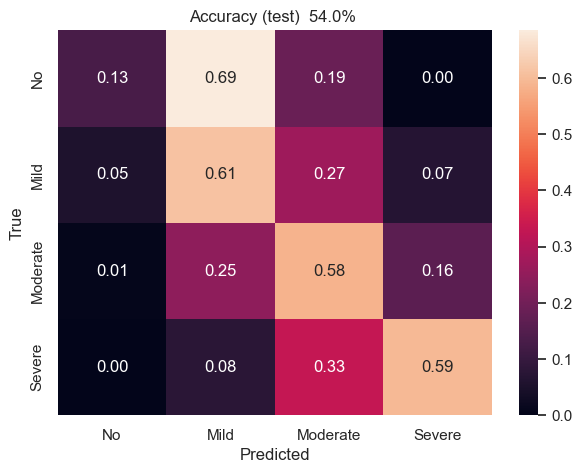

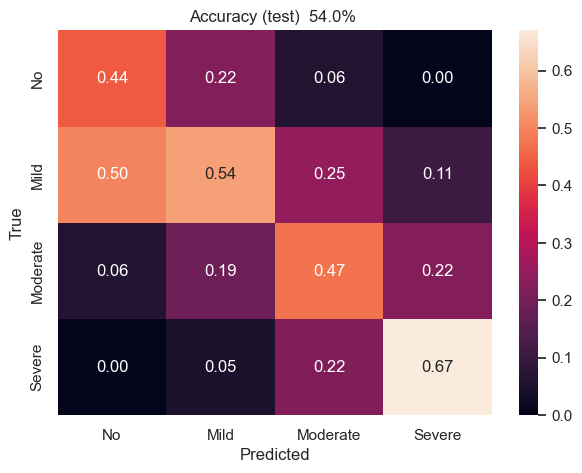

0.5398633257403189

In [32]:
mdl = best_xgbr

y_hat = mdl.predict(X_test)
y_true = Y_test_reg[:,5]

y_hat_clas = ahi_to_category_vf(y_hat)
y_true_clas = Y_test_clas


r2 = r2_score(y_true=y_true, y_pred=y_hat)
mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
y_mean = np.mean(y_true)
accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)

print(f"Test R^2: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
print("---------------------------------------------------------------")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")